In [1]:
!pip install pandas kagglehub seaborn matplotlib scikit-learn torch

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_fscore_support
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os # For file path joining
import kagglehub
import time

In [3]:
# Download latest version
PATH = kagglehub.dataset_download("ellipticco/elliptic-data-set")
print("Path to dataset files:", PATH)


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1


In [4]:
N_FEATURES = 166  # Time step + 165 features
EMBEDDING_DIM = 64
BATCH_SIZE = 256 # Can increase if GPU memory allows
EPOCHS = 15 # Adjust as needed, can take time on full dataset
LEARNING_RATE = 1e-4 #used to be 1e-4
TEMPERATURE = 0.1

In [5]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
print("Loading Elliptic dataset...")
try:
    classes_df = pd.read_csv(PATH + "/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
    features_df = pd.read_csv(PATH + "/elliptic_bitcoin_dataset/elliptic_txs_features.csv")
    edge_df = pd.read_csv(PATH + "/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

    print(classes_df.head(), end="\n\n")
    print(features_df.head(), end="\n\n")
    print(edge_df.head())
except FileNotFoundError:

    print(f"Error: Dataset files not found in {PATH}")
    print("Please download the Elliptic dataset and place it in the correct directory,")
    print("or update the DATA_DIR variable.")
    exit()

Loading Elliptic dataset...
        txId    class
0  230425980  unknown
1    5530458  unknown
2  232022460  unknown
3  232438397        2
4  230460314  unknown

   230425980  1  -0.1714692896288031  -0.18466755143291433  \
0    5530458  1            -0.171484             -0.184668   
1  232022460  1            -0.172107             -0.184668   
2  232438397  1             0.163054              1.963790   
3  230460314  1             1.011523             -0.081127   
4  230459870  1             0.961040             -0.081127   

   -1.2013688016765636  -0.12196959975910057  -0.04387454791734898  \
0            -1.201369             -0.121970             -0.043875   
1            -1.201369             -0.121970             -0.043875   
2            -0.646376             12.409294             -0.063725   
3            -1.201369              1.153668              0.333276   
4            -1.201369              1.303743              0.333276   

   -0.11300200928476244  -0.06158379407303222

In [7]:
#Assign feature headers (txId, Time step, f1 to f165)
feature_headers = ['txId', 'Time step'] + [f'f{i}' for i in range(1, 166)]
features_df.columns = feature_headers
print(features_df.columns)

df = pd.merge(features_df, classes_df, on='txId', how='left')

# Map classes for evaluation: 1 (illicit) -> 1, 2 (licit) -> 0, unknown -> NaN
df['class'] = df['class'].map({'1': 1, '2': 0})

# Separate features (X) and labels (y)
# Features: Time step + f1 to f165
X_cols = ['Time step'] + [f'f{i}' for i in range(1, 166)]
X_all = df[X_cols].values
y_all = df['class'].values # Contains NaN for unknowns

Index(['txId', 'Time step', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       ...
       'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164',
       'f165'],
      dtype='object', length=167)


In [8]:
# Identify known labels for evaluation later
known_indices = df.index[df['class'].notna()].tolist()
y_known = df.loc[known_indices, 'class'].values.astype(int)
txId_known = df.loc[known_indices, 'txId'].values # Keep track of txId if needed

print(f"Total transactions: {len(df)}")
print(f"Transactions with known labels: {len(known_indices)}")
print(f"Illicit (1): {np.sum(y_known == 1)}, Licit (0): {np.sum(y_known == 0)}")

Total transactions: 203768
Transactions with known labels: 46564
Illicit (1): 4545, Licit (0): 42019


In [9]:
# Scale features (fit only on training data, but here we apply to all for unsupervised)
print("Scaling features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

Scaling features...


In [10]:
class EllipticDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return single view for simplified contrastive loss
        return self.features[idx]

# Use all data for unsupervised training
dataset = EllipticDataset(X_all_scaled)
# drop_last=True is important for the artificial pairing in contrastive_loss
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [11]:
class CNNGRUEncoder(nn.Module):
    def __init__(self, input_dim, cnn_channels1=32, cnn_channels2=64,
                 kernel_size=5, pool_kernel=2,
                 gru_hidden_size=128, gru_layers=1, bidirectional=True,
                 embedding_dim=64):
        super(CNNGRUEncoder, self).__init__()
        self.input_dim = input_dim
        self.conv1 = nn.Conv1d(1, cnn_channels1, kernel_size, padding='same')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(pool_kernel)
        self.conv2 = nn.Conv1d(cnn_channels1, cnn_channels2, kernel_size, padding='same')
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(pool_kernel)

        l_out1 = math.floor(input_dim / pool_kernel)
        l_out2 = math.floor(l_out1 / pool_kernel)
        self.cnn_output_length = l_out2
        self.cnn_output_channels = cnn_channels2

        self.gru = nn.GRU(self.cnn_output_channels, gru_hidden_size, gru_layers,
                          batch_first=True, bidirectional=bidirectional)
        gru_output_dim = gru_hidden_size * (2 if bidirectional else 1)
        self.fc_out = nn.Linear(gru_output_dim, embedding_dim)
        print(f"CNN Output Sequence Length: {self.cnn_output_length}, Channels: {self.cnn_output_channels}")

        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.permute(0, 2, 1)
        _, h_n = self.gru(x)
        if self.gru.bidirectional:
            gru_out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        else:
            gru_out = h_n[-1,:,:]
        embedding = self.fc_out(gru_out)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding

In [12]:
# Instantiate encoder
encoder = CNNGRUEncoder(input_dim=N_FEATURES, embedding_dim=EMBEDDING_DIM).to(DEVICE)
optimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
print("\nCNN-GRU Encoder Architecture:")
print(encoder)

CNN Output Sequence Length: 41, Channels: 64

CNN-GRU Encoder Architecture:
CNNGRUEncoder(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(64, 128, batch_first=True, bidirectional=True)
  (fc_out): Linear(in_features=256, out_features=64, bias=True)
)


In [13]:
def contrastive_loss(z, temperature):
    n = z.shape[0]
    if n % 2 != 0:
         return torch.tensor(0.0, device=DEVICE, requires_grad=True) # Skip odd batches

    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    mask = torch.eye(n, dtype=torch.bool).to(DEVICE)
    sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))

    n_pairs = n // 2
    indices_i = torch.arange(n_pairs).to(DEVICE)
    indices_j = torch.arange(n_pairs, n).to(DEVICE)

    sim_pos = torch.exp(sim_matrix[indices_i, indices_j] / temperature)
    sim_all_neg_i = torch.exp(sim_matrix[indices_i] / temperature).sum(dim=1)
    sim_all_neg_j = torch.exp(sim_matrix[indices_j] / temperature).sum(dim=1)

    loss_i = -torch.log(sim_pos / (sim_all_neg_i + 1e-8))
    loss_j = -torch.log(sim_pos / (sim_all_neg_j + 1e-8)) 
    loss = (loss_i.mean() + loss_j.mean()) / 2
    return loss

In [14]:
print("\nStarting Unsupervised Training with CNN-GRU Encoder...")
encoder.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    batches_processed = 0
    for batch_idx, data in enumerate(dataloader):
        # Artificial pairing for simplified contrastive loss demo
        actual_batch_size = data.shape[0] # Could be smaller than BATCH_SIZE if drop_last=False used
        if actual_batch_size < 2 or actual_batch_size % 2 != 0 : continue # Ensure we have pairs

        data = data.to(DEVICE)
        view1 = data[:actual_batch_size//2]
        view2 = data[actual_batch_size//2:]

        z1 = encoder(view1)
        z2 = encoder(view2)
        z_combined = torch.cat([z1, z2], dim=0)

        loss = contrastive_loss(z_combined, TEMPERATURE)

        optimizer.zero_grad()
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() == 0.0:
             continue
        else:
             loss.backward()
             optimizer.step()
             epoch_loss += loss.item()
             batches_processed += 1

        # Print progress occasionally
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(dataloader)}], Current Loss: {loss.item():.4f}")


    if batches_processed > 0:
        avg_epoch_loss = epoch_loss / batches_processed
        losses.append(avg_epoch_loss)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Avg Training Loss: {avg_epoch_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{EPOCHS}], No valid batches processed.")
        losses.append(float('nan'))

print("Training Finished.")


Starting Unsupervised Training with CNN-GRU Encoder...
Epoch [1/15], Batch [100/795], Current Loss: 5.5763
Epoch [1/15], Batch [200/795], Current Loss: 5.6068
Epoch [1/15], Batch [300/795], Current Loss: 5.5776
Epoch [1/15], Batch [400/795], Current Loss: 5.5682
Epoch [1/15], Batch [500/795], Current Loss: 5.6008
Epoch [1/15], Batch [600/795], Current Loss: 5.5613
Epoch [1/15], Batch [700/795], Current Loss: 5.5694
Epoch [1/15], Avg Training Loss: 5.5830
Epoch [2/15], Batch [100/795], Current Loss: 5.5649
Epoch [2/15], Batch [200/795], Current Loss: 5.5694
Epoch [2/15], Batch [300/795], Current Loss: 5.5685
Epoch [2/15], Batch [400/795], Current Loss: 5.5736
Epoch [2/15], Batch [500/795], Current Loss: 5.5265
Epoch [2/15], Batch [600/795], Current Loss: 5.5602
Epoch [2/15], Batch [700/795], Current Loss: 5.5613
Epoch [2/15], Avg Training Loss: 5.5643
Epoch [3/15], Batch [100/795], Current Loss: 5.5762
Epoch [3/15], Batch [200/795], Current Loss: 5.5534
Epoch [3/15], Batch [300/795], C

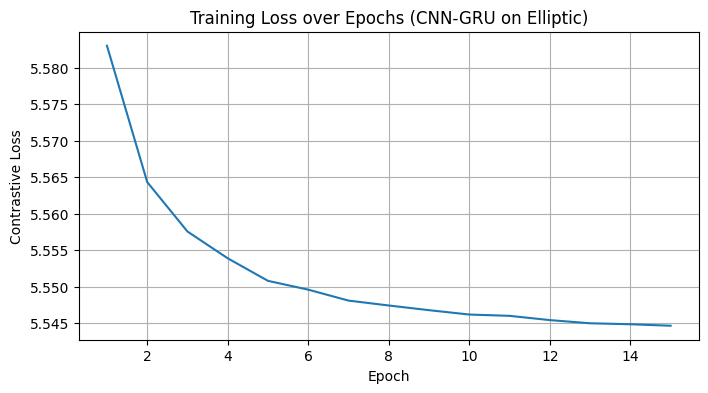

In [15]:
#Plot loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(losses) + 1), losses) # Adjust x-axis range based on actual epochs run
plt.title("Training Loss over Epochs (CNN-GRU on Elliptic)")
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.grid(True)
plt.savefig("elliptic_training_loss_cnngru.png") # Save the plot
plt.show()

In [20]:
print("Generating final embeddings for all data...")
encoder.eval()
all_embeddings_list = []
# Use a dataloader for all data, no shuffling, potentially larger batch
eval_dataset = EllipticDataset(X_all_scaled)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)

with torch.no_grad():
    for data in eval_dataloader:
        data = data.to(DEVICE)
        embeddings = encoder(data)
        all_embeddings_list.append(embeddings.cpu().numpy())

all_embeddings = np.concatenate(all_embeddings_list, axis=0)
print(f"Generated embeddings shape: {all_embeddings.shape}")

# Ensure embeddings count matches original data count
if len(all_embeddings) != len(df):
    print(f"Warning: Embedding count ({len(all_embeddings)}) does not match dataframe rows ({len(df)}). Check dataloading.")
    # Attempt to truncate if slightly off due to batching, but investigate if large difference
    all_embeddings = all_embeddings[:len(df)]

Generating final embeddings for all data...
Generated embeddings shape: (203768, 64)


In [21]:
N_CLUSTERS = 20 # HYPERPARAMETER
ANOMALY_THRESHOLD_PERCENTILE = 95 # HYPERPARAMETER

predicted_anomalies_all = None
cluster_labels = None # K-Means labels (0 to K-1)
distances_to_centroid = None

if all_embeddings is not None:
    print(f"\n--- Starting K-Means Clustering (K={N_CLUSTERS}) ---")
    print(f"Input embeddings shape: {all_embeddings.shape}")

    start_time = time.time()
    try:
        kmeans = KMeans(n_clusters=N_CLUSTERS,
                        init='k-means++', 
                        n_init=10,       # Run multiple times with different seeds
                        max_iter=300,
                        random_state=42, # For reproducibility
                        verbose=2)       # Set to 1 or 2 for more KMeans output
        print("Fitting K-Means model...")
        # Fit K-Means and get cluster labels for each point
        cluster_labels = kmeans.fit_predict(all_embeddings)
        centroids = kmeans.cluster_centers_
        inertia = kmeans.inertia_ # Sum of squared distances of samples to their closest cluster center

        end_time = time.time()
        print(f"K-Means fitting completed in {end_time - start_time:.2f} seconds.")
        print(f"K-Means Inertia: {inertia:.4f}")
        print(f"Found {len(centroids)} centroids.")

        # Calculate distance for each point to its assigned centroid
        print("\nCalculating distances to assigned centroids...")
        distances_to_centroid = np.zeros(all_embeddings.shape[0])
        for i in range(N_CLUSTERS):
            cluster_points_mask = (cluster_labels == i)
            if np.sum(cluster_points_mask) > 0:
                # Use Euclidean distance (L2 norm)
                # Since embeddings are normalized, this relates to cosine distance
                distances_to_centroid[cluster_points_mask] = np.linalg.norm(
                    all_embeddings[cluster_points_mask] - centroids[i], axis=1
                )
        print("Distance calculation finished.")

        # Determine the distance threshold based on percentile
        distance_threshold = np.percentile(distances_to_centroid, ANOMALY_THRESHOLD_PERCENTILE)
        print(f"Using {ANOMALY_THRESHOLD_PERCENTILE}th percentile distance threshold: {distance_threshold:.4f}")

        # Predict anomalies: Points whose distance > threshold
        predicted_anomalies_all = (distances_to_centroid > distance_threshold).astype(int) # 1=anomaly, 0=normal

        n_anomalies_found = np.sum(predicted_anomalies_all)
        print(f"\nNumber of predicted anomalies (distance > threshold): {n_anomalies_found} ({n_anomalies_found / len(all_embeddings) * 100:.2f}%)")

        # Print sizes of the clusters
        unique_labels, counts = np.unique(cluster_labels, return_counts=True)
        print("\nCluster sizes:")
        cluster_counts = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
        for label, count in cluster_counts[:15]: # Print top 15 cluster sizes
             print(f"  Cluster {label}: {count}")


    except MemoryError:
        print("\n--- ERROR: Ran out of memory during K-Means fitting! ---")
        print("This is less common than with DBSCAN but possible. Check resources.")
        # predicted_anomalies_all and cluster_labels remain None

    except Exception as e:
        print(f"\n--- An unexpected error occurred during K-Means: {e} ---")
        # predicted_anomalies_all and cluster_labels remain None

else:
    print("\nSkipping K-Means clustering as embeddings were not generated.")



--- Starting K-Means Clustering (K=20) ---
Input embeddings shape: (203768, 64)
Fitting K-Means model...
Initialization complete
Iteration 0, inertia 1543.5657958984375.
Iteration 1, inertia 1087.694580078125.
Iteration 2, inertia 1065.9517822265625.
Iteration 3, inertia 1057.505126953125.
Iteration 4, inertia 1048.953857421875.
Iteration 5, inertia 1042.348876953125.
Iteration 6, inertia 1038.13916015625.
Iteration 7, inertia 1035.1986083984375.
Iteration 8, inertia 1033.0992431640625.
Iteration 9, inertia 1031.20947265625.
Iteration 10, inertia 1029.435302734375.
Iteration 11, inertia 1027.9669189453125.
Iteration 12, inertia 1026.8818359375.
Iteration 13, inertia 1026.10693359375.
Iteration 14, inertia 1025.5684814453125.
Iteration 15, inertia 1025.052734375.
Iteration 16, inertia 1024.4796142578125.
Iteration 17, inertia 1023.8681640625.
Iteration 18, inertia 1022.8167724609375.
Iteration 19, inertia 1021.8348388671875.
Iteration 20, inertia 1021.277587890625.
Iteration 21, inerti

In [22]:
print("\n--- Evaluating on known licit/illicit transactions ---")

if predicted_anomalies_all is None:
    print("Clustering/Anomaly detection failed or was skipped. Cannot evaluate.")
elif len(known_indices) == 0:
     print("No known labels available in the dataset to evaluate against.")
else:
    # Select predictions corresponding to known labels
    predicted_anomalies_known = predicted_anomalies_all[known_indices]
    # Make sure it handles cases where predicted_anomalies_known might be empty if known_indices was empty
    if len(predicted_anomalies_known) == 0:
         print("No predictions available for known labels. Cannot evaluate.")
    else:
        accuracy = accuracy_score(y_known, predicted_anomalies_known)
        precision, recall, f1, _ = precision_recall_fscore_support(y_known, predicted_anomalies_known, average='binary', pos_label=1, zero_division=0) # Focus on illicit class (1)
        try:
            if len(np.unique(y_known)) > 1 and len(np.unique(predicted_anomalies_known)) > 1:
                 auroc = roc_auc_score(y_known, predicted_anomalies_known)
            else:
                 print("AUROC requires multiple classes in both true labels and predictions. Skipping AUROC calculation.")
                 auroc = float('nan')
        except ValueError as e:
            print(f"Could not calculate AUROC: {e}")
            auroc = float('nan')
        print(f"\nAccuracy (known): {accuracy:.4f}")
        print(f"AUROC (known): {auroc:.4f}")
        print(f"Precision (for illicit=1): {precision:.4f}")
        print(f"Recall (for illicit=1): {recall:.4f}")
        print(f"F1-Score (for illicit=1): {f1:.4f}")
        print("\nClassification Report (known):")
        print(classification_report(y_known, predicted_anomalies_known, target_names=["Licit (0)", "Illicit (1)"], zero_division=0))



--- Evaluating on known licit/illicit transactions ---

Accuracy (known): 0.8159
AUROC (known): 0.4603
Precision (for illicit=1): 0.0200
Recall (for illicit=1): 0.0185
F1-Score (for illicit=1): 0.0192

Classification Report (known):
              precision    recall  f1-score   support

   Licit (0)       0.89      0.90      0.90     42019
 Illicit (1)       0.02      0.02      0.02      4545

    accuracy                           0.82     46564
   macro avg       0.46      0.46      0.46     46564
weighted avg       0.81      0.82      0.81     46564




Visualizing embeddings for known data using PCA...


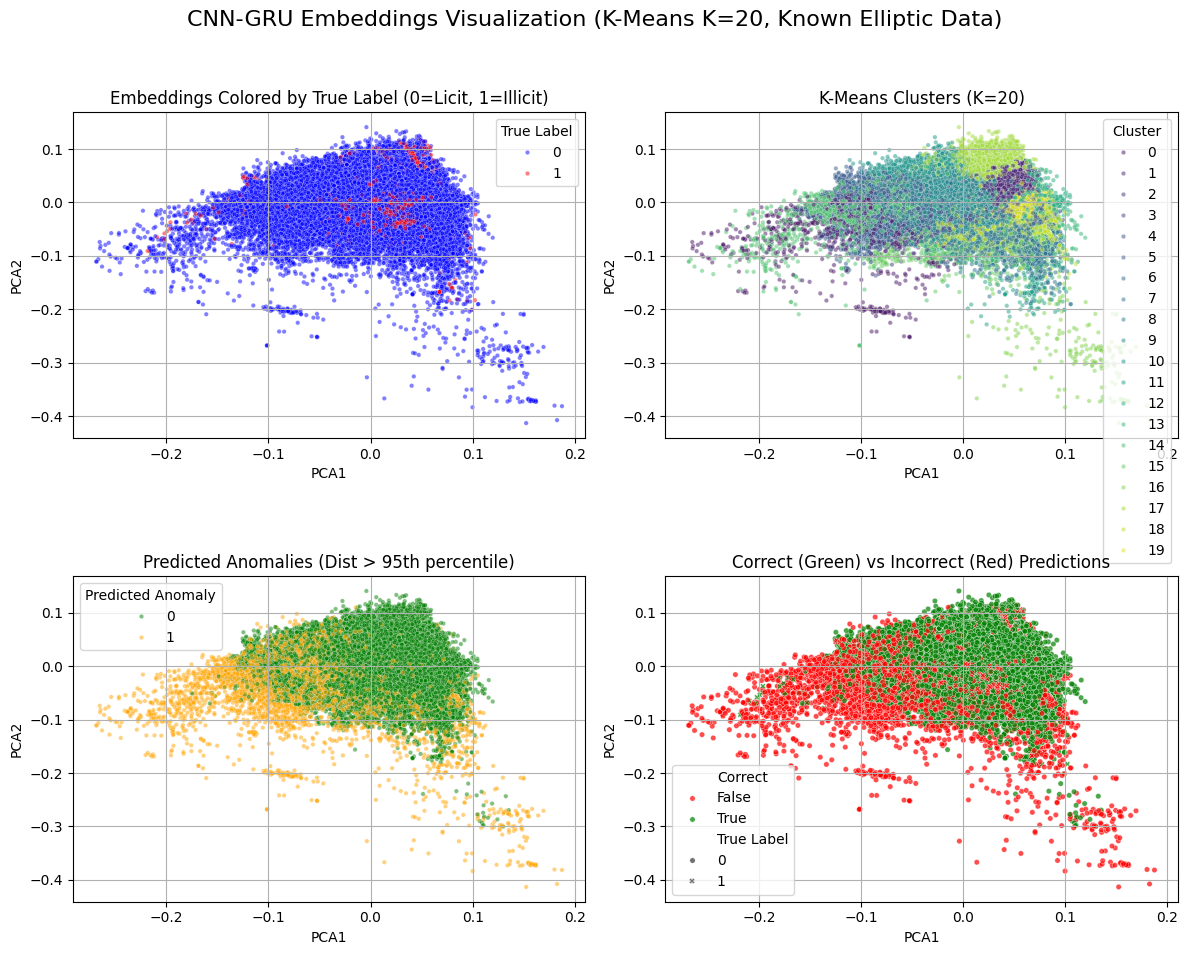


--- Reminder: K-Means parameters (N_CLUSTERS, ANOMALY_THRESHOLD_PERCENTILE) require tuning for good anomaly detection. ---


In [23]:
print("\nVisualizing embeddings for known data using PCA...")
if all_embeddings is None:
     print("Skipping visualization as embeddings were not generated.")
elif len(known_indices) == 0:
     print("Skipping visualization as no known labels are available.")
else:
    embeddings_known = all_embeddings[known_indices]
    try:
        pca = PCA(n_components=2)
        embeddings_known_2d = pca.fit_transform(embeddings_known)

        df_viz = pd.DataFrame({
            'PCA1': embeddings_known_2d[:, 0],
            'PCA2': embeddings_known_2d[:, 1],
            'True Label': y_known
        })

        # Adapt visualization based on whether K-Means succeeded
        if cluster_labels is not None and predicted_anomalies_all is not None:
            df_viz['Cluster'] = cluster_labels[known_indices] # K-Means labels (0 to K-1)
            df_viz['Predicted Anomaly'] = predicted_anomalies_all[known_indices] # 0 or 1 based on distance
            df_viz['Correct'] = (df_viz['True Label'] == df_viz['Predicted Anomaly'])
            n_plots = 4
            figsize=(12, 10)
        else:
            print("Visualizing true labels only, as K-Means results are unavailable.")
            n_plots = 1
            figsize=(7, 6)


        plt.figure(figsize=figsize)
        plt.suptitle(f"CNN-GRU Embeddings Visualization (K-Means K={N_CLUSTERS}, Known Elliptic Data)", fontsize=16)

        # Plot 1: True Labels (Same as before)
        plt.subplot(2, 2, 1) if n_plots == 4 else plt.subplot(1, 1, 1)
        sns.scatterplot(data=df_viz, x='PCA1', y='PCA2', hue='True Label', palette={0: 'blue', 1: 'red'}, s=10, alpha=0.5)
        plt.title('Embeddings Colored by True Label (0=Licit, 1=Illicit)')
        plt.grid(True)

        if n_plots == 4:
            # Plot 2: K-Means Cluster Labels (0 to K-1)
            plt.subplot(2, 2, 2)
            # Use a palette suitable for categorical data (like 'tab20' or 'viridis' with discrete levels)
            unique_kmeans_labels = sorted(df_viz['Cluster'].unique())
            # Ensure palette has enough colors if K is large
            palette = sns.color_palette("viridis", n_colors=len(unique_kmeans_labels))
            cluster_colors = {label: color for label, color in zip(unique_kmeans_labels, palette)}
            sns.scatterplot(data=df_viz, x='PCA1', y='PCA2', hue='Cluster', palette=cluster_colors, s=10, alpha=0.5, legend=None if N_CLUSTERS > 20 else 'full') # Hide legend if too many clusters
            plt.title(f'K-Means Clusters (K={N_CLUSTERS})')
            plt.grid(True)

            # Plot 3: Predicted Anomalies (Based on Distance Threshold) (Same as before)
            plt.subplot(2, 2, 3)
            sns.scatterplot(data=df_viz, x='PCA1', y='PCA2', hue='Predicted Anomaly', palette={0: 'green', 1: 'orange'}, s=10, alpha=0.5)
            plt.title(f'Predicted Anomalies (Dist > {ANOMALY_THRESHOLD_PERCENTILE}th percentile)')
            plt.grid(True)

            # Plot 4: Correct/Incorrect Predictions (Same as before)
            plt.subplot(2, 2, 4)
            sns.scatterplot(data=df_viz, x='PCA1', y='PCA2', hue='Correct', palette={True: 'green', False: 'red'}, style='True Label', markers={0:'o', 1:'X'}, s=15, alpha=0.7)
            plt.title('Correct (Green) vs Incorrect (Red) Predictions')
            plt.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("elliptic_embeddings_vis_cnngru_kmeans.png")
        plt.show()

    except Exception as e:
        print(f"An error occurred during visualization: {e}")

# --- Final Notes ---
# ... (Keep existing notes, maybe add one about tuning K and percentile) ...
print("\n--- Reminder: K-Means parameters (N_CLUSTERS, ANOMALY_THRESHOLD_PERCENTILE) require tuning for good anomaly detection. ---")